## imports and setting up the environment

In [ ]:
import pyannote

# database related imports
from pyannote.database import registry, FileFinder

# training related imports
from pyannote.audio import Pipeline, Model
from pyannote.audio import pipelines
from pyannote.audio.tasks import SpeakerDiarization
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from types import MethodType
from torch.optim import Adam

# metrics related imports
from pyannote.metrics.diarization import DiarizationErrorRate

# other
import os

huggingface_token = os.getenv("HUGGINGFACE_TOKEN")


/home/vicuser/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
registry.load_database("database.yml")

protocol = registry.get_protocol("BP.SpeakerDiarization.VlaamseAudio", {"audio":FileFinder()})

for file in protocol.train():
   assert "annotation" in file
   assert isinstance(file["annotation"], pyannote.core.Annotation)
   assert "annotated" in file
   assert isinstance(file["annotated"], pyannote.core.Timeline)


/home/vicuser/.local/lib/python3.10/site-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing BP.SpeakerDiarization.VlaamseAudio protocol by the one defined in '/home/vicuser/bp-stemmen-onderscheiden/pyannote/database.yml'.
  warnings.warn(


In [3]:
database = registry.get_database("BP")

database.get_tasks()

['SpeakerDiarization']

In [4]:
protocol.__class__

pyannote.database.custom.BP__SpeakerDiarization__VlaamseAudio

## pretrained pyannote pipeline

In [5]:
# get the model from the pipeline
pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=huggingface_token)


current error rate of the pipeline (possibly very slow)

In [7]:
metric = DiarizationErrorRate()

for file in protocol.test():
    print(file)
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

Diarization error rate is 0.0% for the pretrained model


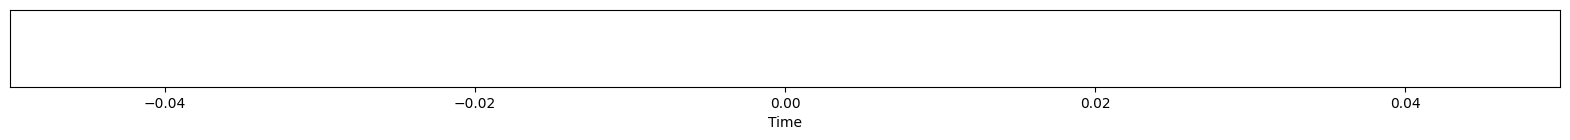

In [9]:
file["annotated"]

## train the model

In [51]:
pretrained_segm_model = Model.from_pretrained("pyannote/segmentation", use_auth_token=huggingface_token)
output_dir = "./models"

task = SpeakerDiarization(
    protocol=protocol,
    batch_size=32,
    vad_loss="bce"
)

pretrained_segm_model.task = task
pretrained_segm_model.prepare_data()
pretrained_segm_model.setup()

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/660b9e20307a2b0cdb400d0f80aadc04a701fc54/pytorch_model.bin`


/home/vicuser/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.


   -   6.33% of all chunks contain no speech at all.
   -  82.41% contain 1 speaker or less
   -  98.73% contain 2 speakers or less
   - 100.00% contain 3 speakers or less
Setting `max_speakers_per_chunk` to 2. You can override this value (or avoid this estimation step) by passing `max_speakers_per_chunk=2` to the task constructor.


/home/vicuser/.local/lib/python3.10/site-packages/pyannote/audio/core/model.py:229: UserWarning: Model has been trained for a different task. For fine tuning or transfer learning, it is recommended to train task-dependent layers for a few epochs before training the whole model: ['activation', 'classifier'].
  warnings.warn(msg)


In [52]:
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)


In [53]:
pretrained_segm_model.configure_optimizers = MethodType(configure_optimizers, pretrained_segm_model)

In [54]:
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False
)

In [55]:
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False
)

In [56]:
callbacks = [RichProgressBar(), checkpoint, early_stopping]

In [57]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs=10,
    gradient_clip_val=0.5
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(pretrained_segm_model)

/home/vicuser/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/vicuser/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃ Mode  ┃      In sizes ┃                           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ train │ [1, 1, 32000] │                        [1, 60, 115] │
│ 1 │ lstm              │ LSTM             │  1.4 M │ train │  [1, 115, 60] │   [[1, 115, 256], [[8, 1, 128], [8, │
│   │                   │                  │        │       │               │                           1, 128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │ train │             ? │                                   ? │
│ 3 │ classifier        │ Linear           │    258 │ train │ [1, 115, 128] │                         [1, 115, 2] │
│ 4 │ activation        │ Sigmoid          │      0 │ train │   [1, 115, 2] │                         [1, 115, 2] │
│ 5 │ validation_metric │ MetricCollection │      0 │ train │             ? │                                   ? │
└───┴───────────────────┴──────────────────┴────────┴───────┴───────────────┴─────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0

/home/vicuser/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` 
has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be 
inaccurate if each worker is not configured independently to avoid having duplicate data.

/home/vicuser/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training 
batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=10` reached.


In [59]:
trained_model = checkpoint.best_model_path

In [60]:
trained_model

'/home/vicuser/bp-stemmen-onderscheiden/pyannote/DiarizationErrorRate/epoch=9-v2.ckpt'

TODO: add finetuning

getrainde model terug in aan de pipeline toevoegen

In [61]:
from pyannote.audio import pipelines
finetuned_pipeline = pipelines.SpeakerDiarization(
    segmentation=trained_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

TODO: instantiate after finetuning [github notebook](https://github.com/pyannote/pyannote-audio/blob/main/tutorials/adapting_pretrained_pipeline.ipynb)

In [62]:
finetuned_pipeline.instantiate(
    pretrained_pipeline.parameters(),
)

test result of trained pipeline

In [63]:
metric = DiarizationErrorRate()

In [64]:
for file in protocol.test():
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])
print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")


print(f"Diarization error rate is {100 * abs(metric):.1f}% for the pretrained model")

RuntimeError: A pipeline must be instantiated with `pipeline.instantiate(parameters)` before it can be applied.